In [1]:
# This Notebook was inspired by Medium's Sebastian Theiler: https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f

In [2]:
# Neccessary imports
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import cifar10, mnist
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential

%matplotlib inline

In [3]:
# Define random seed to have consistent results
np.random.seed(10)

# The dimension of the random noise vector z
noise_dim = 100

# Training parameters
batch_size = 16
steps_per_epoch = 3750 # 60000 / 16
epochs = 21

# Path for saving images
save_path = 'fcgan-images'

# Dimension of the images
img_rows, img_cols, channels = 28, 28, 1

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5)

In [4]:
# Path for saving images
save_path = 'fcgan-images'

# Create path for saving images
if save_path != None and not os.path.isdir(save_path):
    os.mkdir(save_path)

In [5]:
# Load and pre-process data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize to between -1 and 1
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

x_train = x_train.reshape(-1, img_rows*img_cols*channels)

In [6]:
# Function that creates the generator
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [7]:
# Function that creates the generator
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [8]:
# Create the discriminator and generator
discriminator = create_descriminator()
generator = create_generator()

# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [9]:
# Display images, and save them if the epoch number is specified
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None and save_path != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()

Epoch: 0 	 Discriminator Loss: 0.5303184986114502 		 Generator Loss: 1.5748231410980225


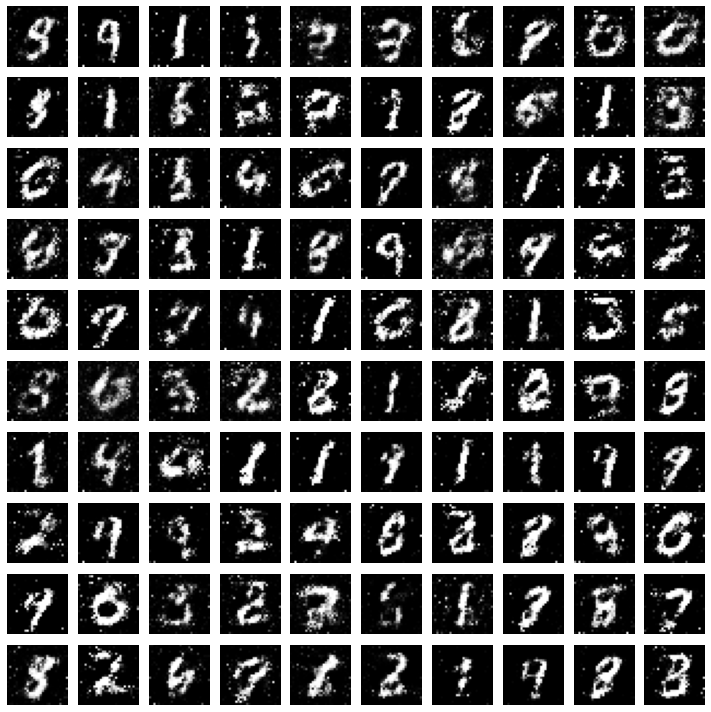

Epoch: 1 	 Discriminator Loss: 0.7161834836006165 		 Generator Loss: 1.668043613433838
Epoch: 2 	 Discriminator Loss: 0.5688445568084717 		 Generator Loss: 1.6162378787994385
Epoch: 3 	 Discriminator Loss: 0.5767030119895935 		 Generator Loss: 1.4931936264038086
Epoch: 4 	 Discriminator Loss: 0.5647064447402954 		 Generator Loss: 1.6517112255096436
Epoch: 5 	 Discriminator Loss: 0.5672162771224976 		 Generator Loss: 1.5226587057113647
Epoch: 6 	 Discriminator Loss: 0.551983654499054 		 Generator Loss: 1.6584281921386719
Epoch: 7 	 Discriminator Loss: 0.619391918182373 		 Generator Loss: 1.592406153678894
Epoch: 8 	 Discriminator Loss: 0.5757919549942017 		 Generator Loss: 1.7466970682144165
Epoch: 9 	 Discriminator Loss: 0.5291357636451721 		 Generator Loss: 1.9735805988311768
Epoch: 10 	 Discriminator Loss: 0.62684166431427 		 Generator Loss: 1.6338456869125366


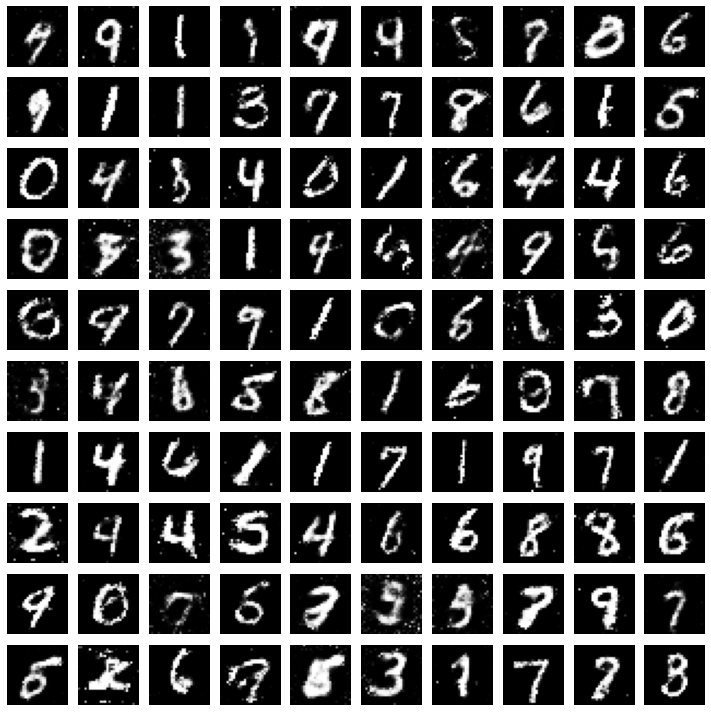

Epoch: 11 	 Discriminator Loss: 0.6090713739395142 		 Generator Loss: 1.4582231044769287
Epoch: 12 	 Discriminator Loss: 0.707857072353363 		 Generator Loss: 1.3035573959350586
Epoch: 13 	 Discriminator Loss: 0.6704093217849731 		 Generator Loss: 1.534684658050537
Epoch: 14 	 Discriminator Loss: 0.5658839344978333 		 Generator Loss: 1.5861555337905884
Epoch: 15 	 Discriminator Loss: 0.5579965114593506 		 Generator Loss: 1.3909780979156494
Epoch: 16 	 Discriminator Loss: 0.543260931968689 		 Generator Loss: 1.5826053619384766
Epoch: 17 	 Discriminator Loss: 0.5616375207901001 		 Generator Loss: 1.5604135990142822
Epoch: 18 	 Discriminator Loss: 0.6453250050544739 		 Generator Loss: 1.7385579347610474
Epoch: 19 	 Discriminator Loss: 0.5192041397094727 		 Generator Loss: 1.5449124574661255
Epoch: 20 	 Discriminator Loss: 0.6066145896911621 		 Generator Loss: 1.403024435043335


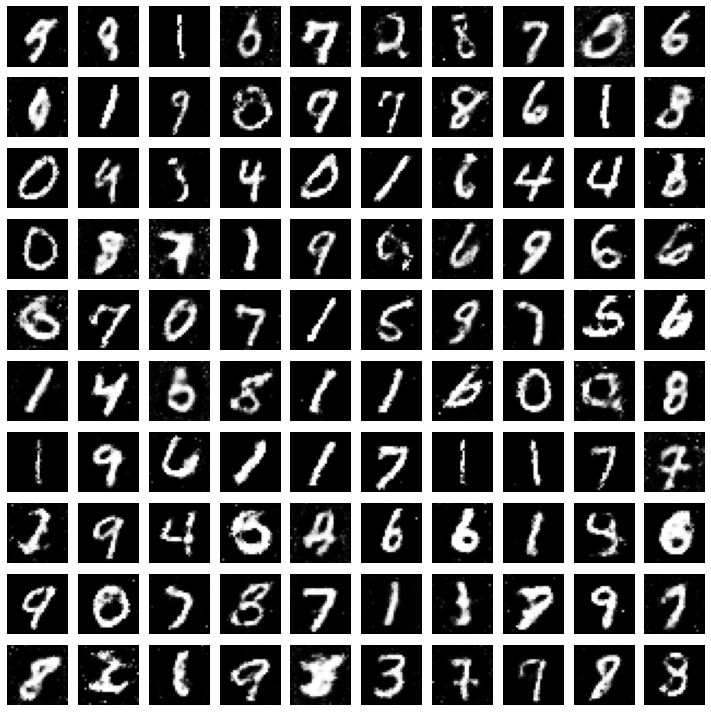

In [10]:
# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    if epoch % 10 == 0:
        show_images(static_noise, epoch)

In [11]:
# Turn the training process into a GIF
from PIL import Image, ImageDraw

frames = []
for image in os.listdir(save_path):
    frames.append(Image.open(save_path + '/' + image))
frames[0].save('gan_training.gif', format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)

discriminator.save('fcdiscriminator.hdf5')
generator.save('fcgenerator.hdf5')